In [2]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


params = {'legend.fontsize' :  10,
          'figure.figsize'  :  (10, 10),
          'axes.labelsize'  :  14,
          'axes.titlesize'  :  14,
          'xtick.labelsize' :  15,
          'ytick.labelsize' :  15}
plt.rcParams.update(params)

In [8]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [42]:
waves= np.linspace(7,12,61)
lps = range(0,359,1)

In [39]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 53.51 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [11]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC0519polarized.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')

In [12]:
#first, determine reference temp for each camera
df_ref = create_LUT_df(path,'0deg.h5')

tref1 =  df_ref['temps1'].value_counts().idxmax() #most common FPA temp
tref2 =  df_ref['temps2'].value_counts().idxmax() #most common FPA temp

print('Ref T1 is '+ str(tref1))
print('Ref T2 is '+ str(tref2))

Ref T1 is 9.2
Ref T2 is 9.8


In [14]:
#load dark field correction
df_dark = create_LUT_df('/Volumes/KESU/may19/polarized/','dark1.h5')

#correct DFC images for reference temp

'''determine DFC in camera 1 '''
D1s = [];
for i in range(len(df_dark)):
    corr = (tref1 - df_dark['temps1'][i])*M1
    offset = (df_dark['imgs1'][i]- corr)
    D1s.append(offset)
D1 = np.mean(D1s, axis =0)    
    
'''determine DFC in camera 1 '''
D2s = [];
for i in range(len(df_dark)):
    corr   = (tref2 - df_dark['temps2'][i])*M2
    offset = (df_dark['imgs2'][i]- corr)
    D2s.append(offset)
D2 = np.mean(D2s, axis =0)    

In [15]:
def DFC(im,t,tref,D,M):
    dark_corr = D + (tref-t)*M
    return(im-dark_corr)

def apply_DFC_to_df(df,D1,D2,tref1,tref2,M1,M2):
    imgs1 = []; temps1 = []
    imgs2 = []; temps2 = []
    for i in range(len(df)):
        im1  = df['imgs1'][i]
        t1   = df['temps1'][i]
        im1c =DFC(im1,t1,tref1,D1,M1)# take offset
        im1c = im1c + (tref1-t1)*M1 #rescale gain
        
        im2  = df['imgs2'][i]
        t2   = df['temps2'][i]
        im2c =DFC(im2,t2,tref2,D2,M2) 
        im2c = im2c + (tref2-t2)*M2 #rescale gain

        imgs1.append(im1c);temps1.append(t1)
        imgs2.append(im2c);temps2.append(t2)
        
    data_corrected = {'imgs1': imgs1,'imgs2': imgs2,'temps1': temps1, 'temps2' : temps2}
    df_corrected = pd.DataFrame.from_dict(data_corrected)
    return(df_corrected)

In [43]:
#apply pixel registration and NUC to full dataset
mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]
t1s = []
t2s = []

for i in lps:
    #will create a df and print the names of the keys in the original hdf5 file
    df_i = create_LUT_df(path,str(round(i))+'deg.h5')
    
    #apply 2 point NUC, this df cooresponds to Cij
    df = apply_DFC_to_df(df_i,D1,D2,tref1,tref2,M1,M2)
    
    corrected_images1= [] ; 
    corrected_images2= [] ; 
    
    for i in range(len(df)):
        #load image
        rn = df['imgs1'][i];
        
        #apply pixel registration, this returns C lambda, phi
        T  = df['temps1'][i];
        t1s.append(T)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        corrected_images1.append(cn)
  

    for i in range(len(df)):
        #load image
        rn = df['imgs2'][i];
        
        #apply pixel registration
        T  = df['temps2'][i];
        t2s.append(T)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        corrected_images2.append(cn)
        

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))

    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))

In [44]:
df = {'lps': lps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}


In [45]:
df = pd.DataFrame.from_dict(df, orient='index')
df = df.transpose()

In [30]:
def finv(y,A,B):
    return np.abs(((y-B)/A))**0.5


In [46]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "LUT0519.h5" 

hf = h5py.File(save_path+name, 'r')
gamma1 = hf.get('gamma1')
gamma2 = hf.get('gamma2')

In [47]:
X,Y = np.meshgrid(waves,angles)
spath = '/Volumes/KESU/may19/polarized/images/'

for j in range(len(lps)):
    I1 = (df['ims1'][j])/gamma1
    I2 = (df['ims2'][j])/gamma2 
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

    pl1 = axes[0].pcolormesh(X,Y,I1 ,shading ='auto' ,cmap = "viridis")
    pl1.set_clim([0,500])
    axes[0].set_ylabel('Angular FOV [$^\circ$]')
    axes[0].set_xlabel('Wavelength [$\mu m$]')
    axes[0].set_title('Camera 1, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')


    pl2 = axes[1].pcolormesh(X,Y,I2,shading ='auto' ,cmap = "viridis")
    pl2.set_clim([0,500])
    axes[1].set_xlabel('Wavelength [$\mu m$]')
    axes[1].set_title('Camera 2, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')

    cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
    cbar.ax.set_ylabel('\n Response - Offset [ADU]',fontsize = 12)

    fig.savefig(spath +'plot'+str(j)+'.png')
    plt.close()

In [48]:
'''animate'''
import imageio
from pathlib import Path

image_path = Path(spath)
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite(spath +'images.gif', image_list,fps = 1)    

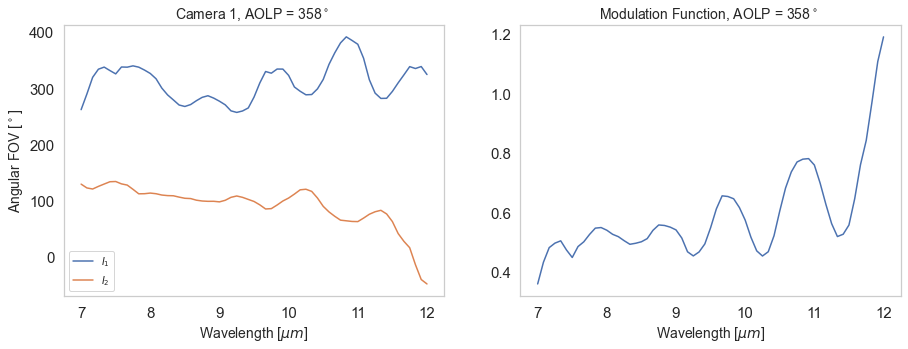

In [86]:
mod = (I1[30:40]/gamma1-I2[25:35]/gamma2)/(I1[30:40]/gamma1+I2[25:35]/gamma2)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =False)

axes[0].plot(waves,np.mean(I1,0)/gamma1,label = '$I_1$')
axes[0].plot(waves,np.mean(I2,0)/gamma2,label = '$I_2$')
axes[0].set_ylabel('Angular FOV [$^\circ$]')
axes[0].set_xlabel('Wavelength [$\mu m$]')
axes[0].set_title('Camera 1, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')
axes[0].legend()


pl2 = axes[1].plot(waves,np.mean(mod,0))
axes[1].set_xlabel('Wavelength [$\mu m$]')
axes[1].set_title('Modulation Function, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')

plt.show()

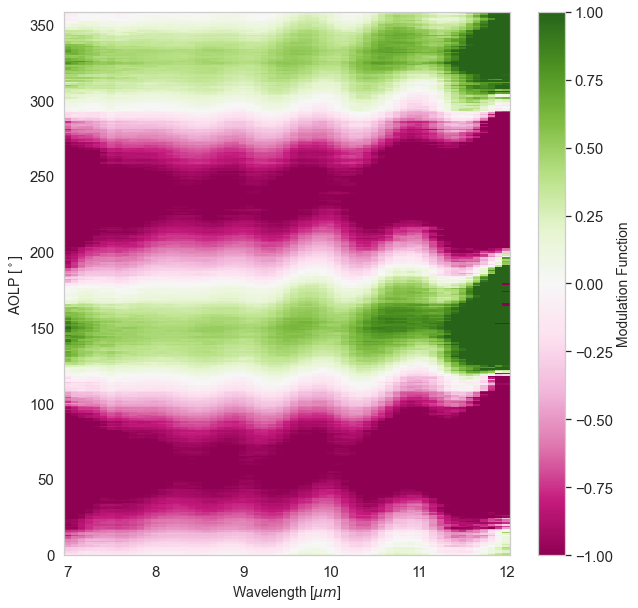

In [54]:
F1 = np.zeros([len(lps),61])
for j in range(len(lps)):
    f1 = np.mean(df['ims1'][j],0)
    f2 = np.mean(df['ims2'][j] ,0)
    F1[j] =(f1-f2)/(f1+f2)
X,Y = np.meshgrid(waves,lps)
plt.pcolormesh(X,Y,F1 - .15,shading ='auto' ,cmap = "PiYG")
plt.ylabel('AOLP [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.colorbar(label = "Modulation Function")
plt.clim(-1,1)
plt.show()

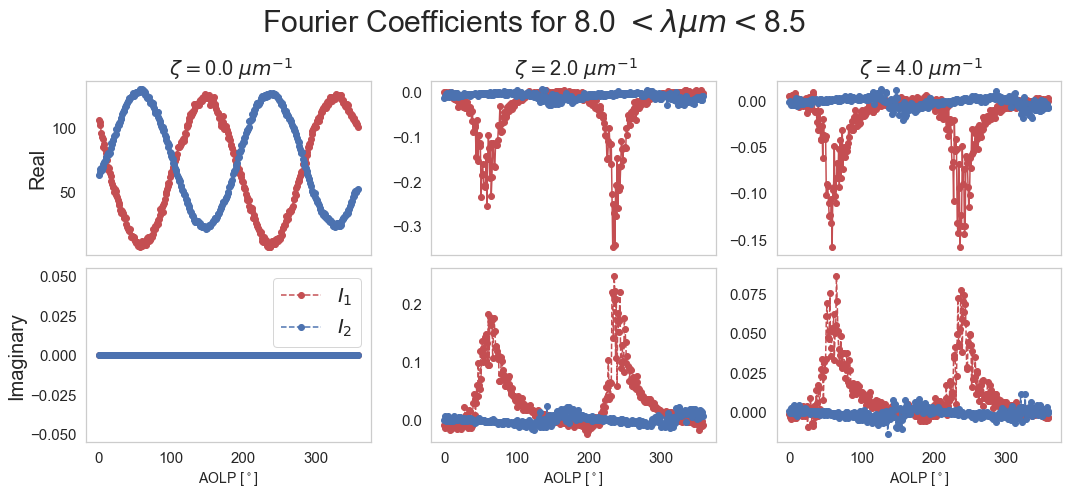

In [80]:
start = 12;
lstart = 0  + start;
lstop  = 6 + start;

dt = waves[1]-waves[0]
freq = np.fft.fftfreq(lstop-lstart, dt)

coef_re1   = np.zeros([len(lps),len(freq)]);
coef_re2   = np.zeros([len(lps),len(freq)]);
coef_im1   = np.zeros([len(lps),len(freq)]);
coef_im2   = np.zeros([len(lps),len(freq)]);


for j in range(len(lps)):

    f1 = np.mean(df['ims1'][j]/gamma1,0)[lstart:lstop]
    f2 = np.mean(df['ims2'][j]/gamma2,0)[lstart:lstop]
    f = (f1-f2)/(f1+f2)
    
    # perform FT and multiply by dt
    ft1 = np.fft.fft(f1) * dt
    ft2 = np.fft.fft(f2) * dt
    
    coef_re1[j] = np.real(ft1)
    coef_re2[j] = np.real(ft2)
    coef_im1[j] = np.imag(ft1)
    coef_im2[j] = np.imag(ft2)


fig, axes = plt.subplots(ncols= 3,nrows = 2 ,figsize=(15, 7), tight_layout=True ,sharey =False,sharex = True)
coefs = [[0,1,2],[0,1,2]]
for j in range(3):
    i = 0;
    axes[i][j].set_title(" $\zeta = $"+ str(np.round(freq[coefs[i][j]],2))+ ' $\mu m^{-1}$',fontsize = 20)
    if j ==0:
        axes[i][j].set_ylabel('Real',fontsize = 20)
        axes[i][j].plot(lps, coef_re1[:,coefs[i][j]],'ro-',label = '$I_1$')
        axes[i][j].plot(lps, coef_re2[:,coefs[i][j]],'bo-',label = '$I_2$')
    else:
        axes[i][j].plot(lps, coef_re1[:,coefs[i][j]]/coef_re1[:,coefs[0][0]],'ro-',label = '$I_1$')
        axes[i][j].plot(lps, coef_re2[:,coefs[i][j]]/coef_re2[:,coefs[0][0]],'bo-',label = '$I_2$')
        
    
    i = 1;
    axes[i][j].plot(lps, coef_im1[:,coefs[i][j]]/coef_re1[:,coefs[0][0]],'ro--',label = '$I_1$')
    axes[i][j].plot(lps, coef_im2[:,coefs[i][j]]/coef_re2[:,coefs[0][0]],'bo--',label = '$I_2$')
        
    axes[i][j].set_xlabel('AOLP [$^\circ$]')
    if j == 0:
        axes[i][j].legend(fontsize = 20)
        axes[i][j].set_ylabel('Imaginary',fontsize = 20)    
            
fig.suptitle('Fourier Coefficients for ' + str(round(waves[lstart],2)) +" $ < \lambda \mu m < $"+ str(round(waves[lstop],2)),fontsize =30)
plt.show()


In [81]:
c11 =[]
c21 =[]
i11 =[]
i21 =[]
coef = 1

center = []
for delta_l in range(50):
    lstart = 0  + delta_l;
    lstop  = 12 + delta_l;

    center.append(round(waves[int(6 + delta_l)],2))
    dt = waves[1]-waves[0]
    freq = np.fft.fftfreq(lstop-lstart, dt)

    coef_re1   = np.zeros(len(lps));
    coef_re2   = np.zeros(len(lps));
    coef_im1   = np.zeros(len(lps));
    coef_im2   = np.zeros(len(lps));

    for j in range(len(lps)):

        f1 = np.mean(df['ims1'][j][10:40],0)[lstart:lstop]
        f2 = np.mean(df['ims2'][j][15:45],0)[lstart:lstop]

        # perform FT and multiply by dt
        ft1 = np.fft.fft(f1) * dt
        ft2 = np.fft.fft(f2) * dt

        coef_re1[j] = np.real(ft1[coef])
        coef_re2[j] = np.real(ft2[coef])
        coef_im1[j] = np.imag(ft1[coef])
        coef_im2[j] = np.imag(ft2[coef])

    c11.append(coef_re1)
    c21.append(coef_re2)
    i11.append(coef_im1)
    i21.append(coef_im2)

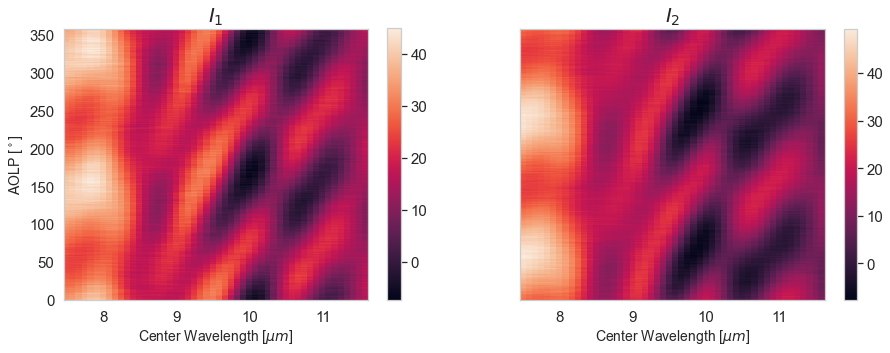

In [82]:
X,Y = np.meshgrid(center , lps)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

pl1 =axes[0].pcolormesh(X,Y,np.transpose(i11)+20,shading = 'auto')
pl2 =axes[1].pcolormesh(X,Y,np.transpose(i21)+20,shading = 'auto')

axes[0].set_ylabel('AOLP [$^\circ$]')
axes[0].set_xlabel('Center Wavelength [$\mu m$]')
axes[0].set_title('$I_1$',fontsize = 20)
fig.colorbar(pl1, ax=axes[0])

axes[1].set_xlabel('Center Wavelength [$\mu m$]')
axes[1].set_title('$I_2$',fontsize = 20)
fig.colorbar(pl2, ax=axes[1])



plt.show()

In [293]:
waves[5]

7.416666666666667